In [ ]:
#|default_exp storage

# Storage 

Macro-X-Ray-Fluorescence (MA-XRF) data typically do not fit into memory. In order to make optimal use of your computer memory and multi-core processors it is therefore necessary to convert such spectral data into a chunked analysis ready file format. The `maxrf4u` package makes use of a specially developed `.datastack` file format. 

In all of the data processing below we will store both the raw data and the results of further computations on disk in a `.datastack` file. The file format is based on the `ZipStore` file format of the [zarr](https://zarr.readthedocs.io/en/stable/tutorial.html#storage-alternatives) python package.  

## Checking the scan orientation  

Before we start our heavy computing, we need to inspect the orientation of the MA-XRF scan data as stored in the `.raw` file. This can be done with the `make_raw_preview()` function.  

In [ ]:
from maxrf4u import make_raw_preview

In [ ]:
#|hide 
import os 

In [ ]:
#|hide
os.chdir('/home/frank/Work/DATA/maxrf4u-data/')

In [ ]:
#|hide
!ls -lh

total 76G
-rw-rw-r-- 1 frank frank 989K Dec 17 15:51 plot.svg
-rw-rw-r-- 1 frank frank  27G Dec 17 15:51 RP-T-1898-A-3689.datastack
-rwxr-xr-x 1 frank frank  29G Apr 24  2023 RP-T-1898-A-3689.datastack_backup
-rw-rw-r-- 1 frank frank 5.2M Jun 11  2024 RP-T-1898-A-3689_FeKa-map-clipped.png
-rw-r--r-- 1 frank frank  22M Jun 25  2019 RP-T-1898-A-3689_highres.png
-rwxr-xr-x 1 frank frank  21G Mar  9  2021 RP-T-1898-A-3689.raw
-rw-rw-r-- 1 frank frank 5.7M Dec  4 11:03 RP-T-1898-A-3689.raw_preview.png
-rwxr-xr-x 1 frank frank  181 Mar  9  2021 RP-T-1898-A-3689.rpl


Saving: RP-T-1898-A-3689.raw_preview.png...


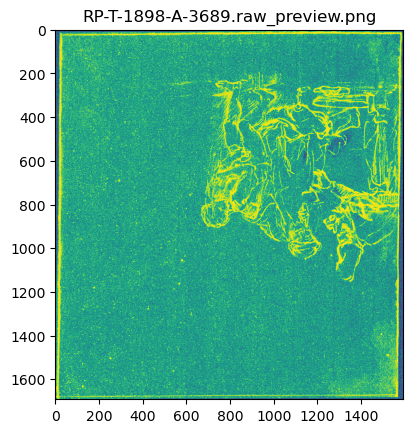

In [ ]:
make_raw_preview('RP-T-1898-A-3689.raw', 'RP-T-1898-A-3689.rpl', show=True);

We see here that the orientation of the raw scan data is rotated 180 degrees. In our next computations we need to take this into account.  

## Creating a .datastack file to do out-of-memory calculations 

In this example below we show how to convert a MA-XRF dataset  consisting of a `.raw` data cube file (and an `.rpl` shape file) into a `.datastack` file. During conversion the `maxrf4u.raw_to_datastack()` function performs a Gaussian smoothing of each spectrum. Also the max and sum spectra are computed and stored. 

On my new laptop this initial conversion of a 21 Gb dataset takes 10:23 minutes. 

In [ ]:
from maxrf4u import raw_to_datastack, tree 

In [ ]:
raw_to_datastack('RP-T-1898-A-3689.raw', 'RP-T-1898-A-3689.rpl', flip_horizontal=True, flip_vertical=True)

Please wait while preparing data conversion...
Creating memory map...
Writing: RP-T-1898-A-3689.datastack...
[########################################] | 100% Completed | 111.42 s
Computing max spectrum...
[########################################] | 100% Completed | 217.51 s
Computing sum spectrum...
[########################################] | 100% Completed | 223.72 s


It is now possible to check the content (i.e. the datasets) of the .datastack file with the `tree()` function. 

In [ ]:
tree('RP-T-1898-A-3689.datastack')

RP-T-1898-A-3689.datastack:

/
 ├── maxrf_cube (1692, 1592, 4096) float32
 ├── maxrf_maxspectrum (4096,) float32
 └── maxrf_sumspectrum (4096,) float64


With the `show_arrays=True` option the `tree()` function also shows the shapes and chunk sizes of the individual datasets. For example, the `maxrf_cube` dataset contains `1692 x 1592` spectra with `4096` channels each. 

In [ ]:
tree('RP-T-1898-A-3689.datastack', show_arrays=True)

RP-T-1898-A-3689.datastack:

/
 ├── maxrf_cube (1692, 1592, 4096) float32
 ├── maxrf_maxspectrum (4096,) float32
 └── maxrf_sumspectrum (4096,) float64


With the freshly created `.datastack` file it is now possible to further explore and process the data. Let's start this exploration by plotting numpy arrays that are returned by the `.read(<datapath>)` methods. The max and sum spectra provide a good summary of the spectral data. The horizontal axis shows the detector channel numbers. Note that inconveniently the data does not provide an energy calibration yet. 

In [ ]:
from maxrf4u import DataStack 

In [ ]:
ds = DataStack('RP-T-1898-A-3689.datastack')

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 

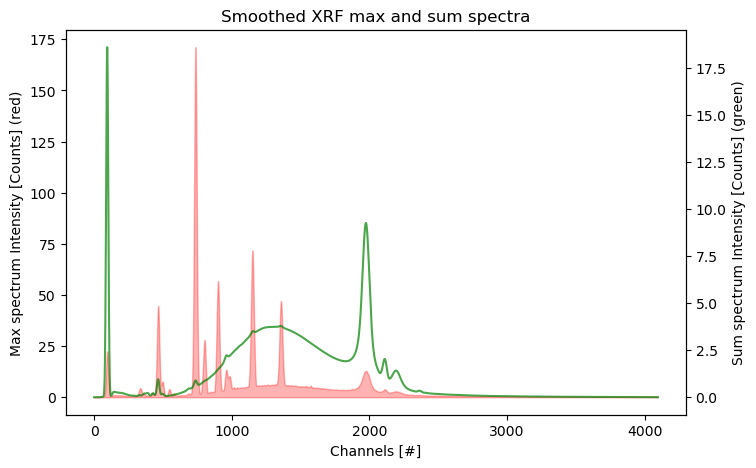

In [ ]:
y_max = ds.read('maxrf_maxspectrum')
y_sum = ds.read('maxrf_sumspectrum')

fig, ax = plt.subplots(figsize=[8, 5])
ax2 = ax.twinx()
ax.fill_between(np.arange(len(y_max)), y_max, color='r', alpha=0.3)
ax2.plot(y_sum, color='g', alpha=0.7)
ax.set_title('Smoothed XRF max and sum spectra')
ax.set_xlabel('Channels [#]')
ax.set_ylabel('Max spectrum Intensity [Counts] (red)')
ax2.set_ylabel('Sum spectrum Intensity [Counts] (green)'); 

## Appending and reading arrays and ragged lists 

In the code above a new `.datastack` file was created to store the converted MA-XRF data and further computations. If these computed results are shaped as a regular array one can use the `append()` function and `DataStack.read()` method for writing to and reading from the `.datastack` file. 

However, we will also come across situations in which we want to store and read irregular (ragged) lists of lists. In these cases one needs to make use of the `append_list()` function and the `DataStack.read_list()` method. 

Here is a small example to demonstrate this functionality. 

In [ ]:
from maxrf4u import append_list, DataStack

In [ ]:
# write 
my_test_ragged_list = [[1, 2], [3, 5, 7], [1]]
append_list(my_test_ragged_list, 'test_list', 'RP-T-1898-A-3689.datastack')

# and read 
ds = DataStack('RP-T-1898-A-3689.datastack')
ds.read_list('test_list')

[[1, 2], [3, 5, 7], [1]]

## FUNCTIONS

In [ ]:
#|export 

import maxrf4u

import numpy as np 
import dask 
import dask.array as da 
from dask.diagnostics import ProgressBar 
#import dask_ndfilters # obsolete 
from dask_image.ndfilters import gaussian_filter
import re 
import os 
import zarr 
from zarr.storage import ZipStore 
from IPython.display import HTML 
import cv2
import matplotlib.pyplot as plt 
import scipy.signal as ssg 
import time 
import skimage as sk 
from pathlib import Path

In [ ]:
#|export 

# CONSTANTS 
DATASTACK_EXT = '.datastack' 


# COMPUTION ORDER 

class Layers: 
    
    def __init__(self): 
        
        self.LAYERS = ['MAXRF_CUBE', 
                       'MAXRF_MAXSPECTRUM', 
                       'MAXRF_SUMSPECTRUM', 
                       'MAXRF_ENERGIES', 
                       'HOTMAX_PIXELS', 
                       'HOTMAX_SPECTRA', 
                       'HOTMAX_BASELINES', 
                       'HOTMAX_NOISELINES', 
                       'MAPS_IMVIS'] 
        
        for l in self.LAYERS: 
            setattr(self, l, l.lower())

L = Layers()




# functions 

def raw_to_datastack(raw_file, rpl_file, output_dir=None, datapath=L.MAXRF_CUBE, verbose=True, 
                    flip_horizontal=False, flip_vertical=False): 
    '''Convert Bruker Macro XRF (.raw) data file *raw_filename* and (.rpl) shape file *rpl_filename*.  
    
    into a Zarr Zipstore datastack file (.datastack).
    ''' 

    print('Please wait while preparing data conversion...')
    
    # generate datastack file path from raw_file and output_dir   
    if output_dir is None: 
        # save in same folder 
        datastack_file = re.sub('\\.raw$', '', raw_file) + DATASTACK_EXT 
        
    else: 
        # save in output folder 
        assert os.path.exists(output_dir),  'Can not save to non-existing directory.'     
        basename = os.path.basename(raw_file) 
        basename = re.sub('\\.raw$', '', basename) + DATASTACK_EXT
        datastack_file = os.path.join(output_dir, basename)
        
    # read data cube shape and dtype from .rpl file 
    dtype, shape = parse_rpl(rpl_file, verbose=verbose)
    
    # create numpy memory map with proper orientation 
    v_stride = 1
    h_stride = 1
    if flip_vertical: 
        v_stride = -1
    if flip_horizontal:
        h_stride = -1 
    
    print('Creating memory map...')
    raw_mm = np.memmap(raw_file, dtype=dtype, mode='r', shape=shape)[::v_stride, ::h_stride] 

    # initializing dask array 
    arr = da.from_array(raw_mm) 
    arr = arr.astype(np.float32)
    
    # schedule spectral gaussian smoothing computation  
    smoothed = gaussian_filter(arr, (0, 0, 7)) 

    # trying to fix error with irregular chunking (not working)
    # smoothed.rechunk(balance=True) 
    # therefore now trying with explicit chunk sizes 
    smoothed.rechunk((100, 100, 100)) 
    
    # create and open an empty zip file
    zs = ZipStore(datastack_file, mode='w') 
    
    if verbose: 
        print(f'Writing: {datastack_file}...')

    # compute and write maxrf data to zipstore 
    with ProgressBar(): 
        smoothed.to_zarr(zs, component=datapath) 
        
    zs.close()
    
    # compute sum and max spectra and append to zipstore 
    
    y_max, y_sum = max_and_sum_spectra(datastack_file, datapath=L.MAXRF_CUBE)
    
    append(y_max, L.MAXRF_MAXSPECTRUM, datastack_file)
    append(y_sum, L.MAXRF_SUMSPECTRUM, datastack_file)
    
    

def tree(datastack_file, show_arrays=False): 
    '''Prints content tree of *datastack_file* '''

    with ZipStore(datastack_file) as zs: 
        root = zarr.open_group(store=zs, mode='r') 
        tree = root.tree().__repr__() # removed expand=True for now 
        print(f'{datastack_file}:\n\n{tree}')  
        
        if show_arrays:        
            datasets = sorted(root)
            arrays_html = ''

            for ds in datasets: 
                arr = da.from_array(root[ds])
                html = arr._repr_html_()
                arrays_html = f'{arrays_html}- Dataset: <h style="color:brown">{ds}</h>{html}' 
   
            return HTML(arrays_html)

def underscorify(datapath, datapath_list, extra_underscore=True): 
    '''Append extra underscore if *datapath* exists to prevent overwriting. 
    
    If *extra_underscore=False* return (latest) datapath with most underscores'''
    
    if datapath in datapath_list: 
        r = re.compile(f'{datapath}_*$')
        datapath = sorted(filter(r.match, datapath_list))[-1]
        
        if extra_underscore: 
            datapath = datapath + '_'
        
    return datapath 


def append(arr, datapath, datastack_file): 
    '''Add numpy or dask array *arr* to *datastack_file* in folder *datapath*.'''
    
    if not isinstance(arr, dask.array.Array):  
        arr = da.from_array(arr) 
            
    zs = ZipStore(datastack_file, mode='a')     
    root = zarr.open_group(store=zs, mode='r')
    
    # append underscores to make unique if datapath exists 
    datapath_list = sorted(root) 
    datapath = underscorify(datapath, datapath_list)

    # write to datastack 
    zarr.create_array(store=zs, name=datapath, data=arr)
    zs.close()

    # old code using dask but not working      
    #arr.to_zarr(zs, component=datapath)

        
def append_list(ragged_list, datapath, datastack_file, nan=-9999): 
    '''Wrapper around append() to store iregular (ragged) lists of lists as regular padded arrays.  
    
    Currently only working for two dimensional lists of integers. Padding is done with nan=-9999. 
    ''' 
    
    padded_array = _straighten(ragged_list, nan=nan) 
        
    append(padded_array, datapath, datastack_file) 
    

def repack(datastack_file, select='all', overwrite=True, verbose=False): 
    '''Repack *datastack_file* by deleting and renaming all but latest datasets. 
    
    Automatic selection of latest datasets can be overriden be providing list of *select* datasets''' 
    
    if verbose: 
        tree(datastack_file)
    
    # open existing zipstore  
    zs = ZipStore(datastack_file) 
    root = zarr.open_group(store=zs, mode='r')
    datapath_list = sorted(root)  
    
    # select newest version (most underscores) for all datasets
    if select == 'all': 
        selected = sorted(set([underscorify(dp, datapath_list, extra_underscore=False) for dp in datapath_list])) 
    # select newest version (most underscores) for datasets in select
    else: 
        selected = sorted(set([underscorify(dp, datapath_list, extra_underscore=False) for dp in select]))       
    
    # remove underscores 
    renamed = [re.sub('_*$', '', s) for s in selected] 
    
    # create and open new empty zipstore 
    datastack_file_new = datastack_file + '_temp'
    zs_new = ZipStore(datastack_file_new, mode='w') 
    
    # copy selected datasets into new zipstore 
    with ProgressBar(): 
        for src, dst in zip(selected, renamed): 
            print(f'Repacking dataset: \'{src}\'') 
            arr = da.from_array(root[src])
            arr.to_zarr(zs_new, component=dst)
    
    zs.close()
    zs_new.close()
    
    # finally overwrite old with new  
    if overwrite: 
        os.replace(datastack_file_new, datastack_file)
    
    if verbose:
        print()
        tree(datastack_file)
        

def max_and_sum_spectra(datastack_file, datapath=L.MAXRF_CUBE): 
    '''Compute sum spectrum and max spectrum for 'maxrf' dataset in *datastack_file*. 
    
    Returns: *y_sum*, *y_max*'''
    
    # open existing zipstore  
    zs = ZipStore(datastack_file) 
    root = zarr.open_group(store=zs, mode='r')
    
    # initialize dask array 
    arr = da.from_array(root[datapath])
        
    # flatten (better avoid)
    h, w, d = arr.shape 
    #flat_shape = h * w, d
    #with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    #    arr_flat = arr.reshape(flat_shape) #, limit='128 MiB') 
    #
    ## schedule computations 
    #sum_spectrum = arr_flat.sum(axis=0)
    #max_spectrum = arr_flat.max(axis=0)
    sum_spectrum = arr.sum(axis=(0, 1))
    max_spectrum = arr.max(axis=(0, 1))
    
    # compute 
    print('Computing max spectrum...')
    with ProgressBar():
        y_max = max_spectrum.compute() 
    print('Computing sum spectrum...')
    with ProgressBar(): 
        y_sum = sum_spectrum.compute() / (h * w)
        
    zs.close()
     
    return y_max, y_sum 


def make_raw_preview(raw_file, rpl_file, output_dir=None, show=False, save=True, verbose=False): 
    '''
    Create preview image of raw file to inspect scan orientation. 
    '''

    # read data cube shape and dtype from .rpl file
    dtype, shape = parse_rpl(rpl_file, verbose=verbose)
    
    # create numpy memory map 
    raw_mm = np.memmap(Path(raw_file), dtype=dtype, mode='r', shape=shape)  
    
    # create max-spectrum 
    raw_flat = raw_mm.reshape([-1, shape[2]])
    raw_max = np.max(raw_flat, axis=0)
    
    # locate highest peak 
    max_peak_idx = np.argmax(raw_max)
    
    # integrate max peak slice 
    max_peak_map = np.average(raw_mm[:,:,max_peak_idx-10:max_peak_idx+10], axis=2)
    raw_preview = sk.exposure.equalize_hist(max_peak_map) 

    if output_dir is None: 
        # save in same folder 
        preview_file = raw_file + '_preview.png'
        
    else: 
        # save in output folder 
        assert os.path.exists(output_dir),  'Can not save to non-existing directory.'     
        basename = os.path.basename(raw_file) 
        basename = basename + '_preview.png'
        preview_file = os.path.join(output_dir, basename)

    if save: 
        print(f'Saving: {preview_file}...')
        plt.imsave(preview_file, raw_preview) 

    if show: 
        fig, ax = plt.subplots()
        ax.imshow(raw_preview)
        ax.set_title(preview_file)

    return raw_preview 

def parse_rpl(rpl_file, verbose=False): 
    '''Read .rpl shape file and return shape and dtype. '''

    # read data cube shape from .rpl file 
    with open(rpl_file, 'r') as fh: 
        lines = fh.readlines()

    if verbose: 
        print(f'Parsing {rpl_file}: ')
        for l in lines: 
            print(l)
    
    # get rid of spaces and newline characters 
    keys_and_values = dict([re.sub(' |\n', '', l).split('\t') for l in lines]) 
    
    width = int(keys_and_values['width'])
    height = int(keys_and_values['height'])
    depth = int(keys_and_values['depth']) 
    nbytes = int(keys_and_values['data-Length'])

    dtype = f'uint{nbytes*8}'
    shape = (height, width, depth)   

    return dtype, shape
    

class DataStack: 
        
    def __init__(self, datastack_file, mode='r', verbose=False, show_arrays=True): 
        '''Initialize DataStack object from *datastack_file*.''' 
        
        # default computation layers ordering as attributes  
        
        self.LAYERS = L.LAYERS 
        
        for l in L.LAYERS: 
            setattr(self, l, l.lower())
            
        # read datasets from file  
        
        self.mode = mode 
        self.datastack_file = datastack_file 
        
        self.update_attrs()
            
        # print tree 
        if verbose: 
            tree(self.datastack_file, show_arrays=show_arrays) 
            
    def update_attrs(self): 
        
        # populate store attributes 
        self.store = ZipStore(self.datastack_file) 
        self.root = zarr.open_group(store=self.store, mode=self.mode) 
        
        # generic exposure to dask arrays 
        self.datapath_list = sorted(self.root) 
        self.datasets = {dp: da.from_array(self.root[dp]) for dp in self.datapath_list}
        
        # attributify dask arrays 
        # useful for code development, perhaps confusing for users 
        # might turn off this feature later 
        for dp, ds in self.datasets.items(): 
            setattr(self, dp, ds) 
        
            
    def latest(self, datapath): 
        '''Return latest version of datapath. '''
        
        datapath = underscorify(datapath, self.datapath_list, extra_underscore=False)
        
        return datapath 
        
            
    def read(self, datapath, latest=True, compute=True):
        '''Read latest version of dataset for *datapath*
        
        Returns numpy array if dataset exists. Otherwise exits. '''
        
        if datapath in self.datapath_list: 
            if latest: 
                datapath = self.latest(datapath)     
            dataset = self.datasets[datapath] 
            if compute: 
                dataset = dataset.compute()
                
        # no dataset in file        
        else: 
            dataset = None 
            
            self.tree()
            assert False, f'Dataset not found: {datapath}'
    
        return dataset
    
    
    def read_list(self, datapath, latest=True, nan=-9999): 
        '''Thin wrapper for reading padded arrays (ragged lists). 

        Returns ragged list if dataset exists. Current implementation only for 
        two-dimensional (ragged) list of lists. ''' 

        # step 1: read (padded array 
        padded_array = self.read(datapath, latest=latest, compute=True)

        # step 2: convert to ragged list by removing nan values 
        ragged_list = _unstraighten(padded_array, nan=nan)

        return ragged_list 


    
    def tree(self, show_arrays=False): 
        '''Prints content tree of datastack.'''
        
        tree(self.datastack_file, show_arrays=show_arrays)
            

            
    def close(self): 
        '''Close file handle'''
         
        self.store.close()
        self.mode = 'closed' 
        
        print(f'Closed: {self.datastack_file}')             

def _straighten(ragged_list, nan=-9999): 
    '''Utility function to straighten a `ragged_list` of integers indices into a regular (padded) array. 
    
    
    Creates a two dimensional numpy array with empty values padded with nan=-9999. 
    
    Returns: padded_array 
    '''
    
    # determine shape 
    ncols = max([len(idxs) for idxs in ragged_list])
    nrows = len(ragged_list) 
    
    # initialize 
    padded_array = np.ones([nrows, ncols], dtype=int)
    padded_array[:,:] = nan 
    
    # fill 
    
    for i, indices in enumerate(ragged_list): 
        for j, idx in enumerate(indices): 
            padded_array[i, j] = idx 
        
    return padded_array 
    

def _unstraighten(padded_array, nan=-9999):
    '''Convert a numpy `padded_array` of integers filled out with nan's into a ragged list.
    
    
    Returns: a ragged list of lists 
    '''

    ragged_list = []
    
    for row in padded_array: 
        row_list = list(row[row!=nan]) # remove nan's from list  
        ragged_list.append(row_list)

    return ragged_list
    
   